In [158]:
import networkx as nx
import math
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
from copy import deepcopy 
import time
import multiprocessing

In [159]:
def euclidean_distance(a_x, a_y, b_x, b_y):
    return math.sqrt((a_x - b_x)**2 + (a_y - b_y)**2)


ERROR! Session/line number was not unique in database. History logging moved to new session 513


In [160]:
def read_graph(file_path):
    with open(file_path) as f:
        g = nx.Graph()
        for line in f:
            if not line[0].isdigit():
                continue
            node, x, y = line.split()
            node = int(node) - 1
            x = float(x)
            y = float(y)
            g.add_node(node, x=x, y=y)
        
        for u in g.nodes:
            for v in range(u + 1, len(g.nodes)):
                g.add_edge(u, v,
                           distance=euclidean_distance(g.nodes[u]['x'],
                                                        g.nodes[u]['y'],
                                                        g.nodes[v]['x'],
                                                        g.nodes[v]['y']))
        return g

In [161]:
g = read_graph(file_path='wi29.tsp')
len(g.edges)

406

In [162]:
class Indivudal:
    def __init__(self, g):
        num_of_cities = len(g.nodes)
        self.code = np.random.permutation(num_of_cities).tolist()
        self.fitness = self.calc_fitness(g)
        
    def __lt__(self, other):
         return self.fitness < other.fitness
    
    def calc_fitness(self, g):
        dis = 0
        n = len(self.code)
        for i in range(n-1):
            dis += g[self.code[i]][self.code[i+1]]["distance"]
    
        dis += g[self.code[-1]][self.code[0]]["distance"]
        
        return dis

In [163]:
i = Indivudal(g)
i.fitness

118853.19083682958

In [164]:
def mutation(individual, mutation_prob):
    
    do = random.random() <= mutation_prob

    if do:
        n = len(individual.code)
        idx1 = random.randrange(n)
        #lista bez idx1
        allowed = list(set(range(n)).difference({idx1}))
        idx2 = random.choice(allowed)
        temp = individual.code[idx1]
        individual.code[idx1] = individual.code[idx2]
        individual.code[idx2] = temp
        

In [165]:
def selection(population, tournament_size,other_parent=None):
    allowed = list(set(range(len(population))).difference({other_parent}))
    chosen = random.sample(allowed, tournament_size)
    max_fitness = float('inf')
    winner_idx = None
    for idx in chosen:
        if max_fitness > population[idx].fitness:
            winner_idx = idx
            max_fitness = population[idx].fitness
    return winner_idx

In [166]:
#ne radi
def crossover(parent1, parent2,child1,child2):
    #ukrstanje prvog reda
    size = len(parent1.code)
    start, end = sorted(random.sample(range(size), 2))

    child1.code = [-1 for _ in range(size)]
    child2.code = [-1 for _ in range(size)]

    # Kopiraj segment između start i end iz roditelja
    child1.code[start:end] = parent1.code[start:end]
    child2.code[start:end] = parent2.code[start:end]

    # Indeksi za popunjavanje preostalih vrednosti
    idx1 = end % size
    idx2 = idx1

    # Popuni preostale vrednosti u detetu 1 s vrednostima iz drugog roditelja
    while idx1 != start:
        if parent2.code[idx2] not in child1.code:
            child1.code[idx1] = parent2.code[idx2]
            idx1 = (idx1 + 1) % size
        idx2 = (idx2 + 1) % size

    # Indeksi za popunjavanje preostalih vrednosti u detetu 2
    idx1 = end % size
    idx2 = idx1

    # Popuni preostale vrednosti u detetu 2 s vrednostima iz prvog roditelja
    while idx1 != start:
        if parent1.code[idx2] not in child2.code:
            child2.code[idx1] = parent1.code[idx2]
            idx1 = (idx1 + 1) % size
        idx2 = (idx2 + 1) % size

In [167]:
p1 = Indivudal(g)
p2 = Indivudal(g)
c1 = Indivudal(g)
c2 = Indivudal(g)

In [168]:
print(p1.code)
print(p2.code)

crossover(p1,p2,c1,c2)
print(c1.code)
print(c2.code)

[12, 25, 17, 26, 13, 24, 11, 10, 15, 0, 28, 8, 9, 6, 23, 20, 3, 19, 4, 27, 18, 1, 22, 5, 16, 7, 14, 2, 21]
[17, 10, 13, 19, 25, 16, 28, 15, 26, 5, 24, 4, 20, 8, 21, 6, 9, 1, 14, 12, 2, 23, 7, 27, 3, 18, 22, 0, 11]
[17, 10, 13, 25, 28, 15, 26, 24, 20, 8, 21, 6, 9, 12, 23, 3, 0, 19, 4, 27, 18, 1, 22, 5, 16, 7, 14, 2, 11]
[25, 17, 26, 13, 24, 11, 10, 15, 28, 8, 9, 6, 20, 19, 4, 5, 16, 1, 14, 12, 2, 23, 7, 27, 3, 18, 22, 0, 21]


In [169]:
def crossover1(parent1, parent2,child1,child2):
    
    n = len(parent1.code)
    child1_list = []
    child2_list = []
    
    breakpoint = random.randrange(n)
    
    child1_list.extend(parent1.code[:breakpoint])
    child2_list.extend(parent2.code[:breakpoint])
    
    for i in range(breakpoint,n):
        if parent2.code[i] not in child1_list:
            child1_list.append(parent2.code[i])
        if parent1.code[i] not in child2_list:
            child2_list.append(parent1.code[i])
        
    
    for node in parent2.code:
        if node not in child1_list:
            child1_list.append(node)
    for node in parent1.code:
        if node not in child2_list:
            child2_list.append(node)
            
    child1.code,child2.code = child1_list,child2_list

In [181]:
def plot_fitness_iter(best_fitness,xlab,ylab):
    plt.plot([i for i in range(len(best_fitnesses))],best_fitnesses)
    plt.xlabel(xlab)
    plt.ylabel(ylab)


In [182]:
def simple_ga(g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop):
    if not use_elitism :
        elitism_size = 0
        if pop_size % 2 == 1:
            pop_size += 1
    
    best_fitnesses = []
    if use_elitism and (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    
    population = [Indivudal(g) for _ in range(pop_size)]
    best_individual = min(population, key=lambda x: x.fitness)
    best_fitnesses.append(best_individual.fitness)
    new_population = [Indivudal(g) for _ in range(pop_size)]
    
    no_difference = 0
    for i in range(num_iters):
        iter = i
        #print(i)
        if use_elitism:
            population.sort()
            
            new_population[:elitism_size] = population[:elitism_size]
            
        for i in range(elitism_size, pop_size, 2):
            parent1_idx = selection(population, tournament_size, None)
            parent2_idx = selection(population, tournament_size, parent1_idx)
            
            crossover1(population[parent1_idx],
                      population[parent2_idx],
                      new_population[i],
                      new_population[i+1])
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #print(new_population[i].code)
            #print(new_population[i+1].code)
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
        
        population[:] = new_population[:]
        best_individual = min(population, key=lambda x: x.fitness)
        best_fitness = best_individual.fitness
        best_fitnesses.append(best_fitness)
        
        if best_fitness == best_fitnesses[iter]:
            no_difference += 1
        
        if no_difference == Stop:
            break
        #print(best_individual.code)
        #print(best_individual.fitness)
        #print(1 / best_individual.fitness)
        
        
    
    best_individual = min(population, key=lambda x: x.fitness)
    print("Best individual time:")
    print(best_individual.code)
    print(f"Fitness of best indvidual {best_individual.fitness}")
    print(1 / best_individual.fitness)
    
    return best_fitnesses, best_individual.fitness

In [183]:
start = time.time()
#best_fitnesses = simple_ga(g,1000,100,5,0.05,True,10,10)
best_fitnesses,_ = simple_ga(g,pop_size = 1000, num_iters = 100, tournament_size = 5, mutation_prob = 0.05, use_elitism = True, elitism_size = 10,Stop = 10)
end = time.time()
print(f"Execution time {end - start}s")

Best individual time:
[12, 8, 6, 10, 9, 7, 2, 3, 4, 1, 0, 5, 11, 13, 15, 23, 24, 26, 19, 25, 27, 20, 28, 22, 21, 14, 18, 17, 16]
Fitness of best indvidual 33872.226867424215
2.9522712041165663e-05
Execution time 2.6577112674713135s


Text(0, 0.5, 'Fitness')

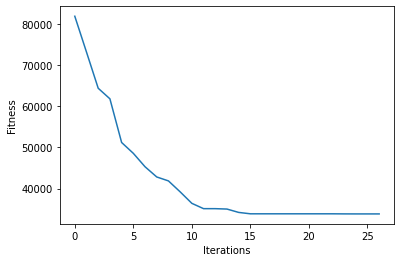

In [186]:
plt.plot([i for i in range(len(best_fitnesses))],best_fitnesses)
plt.xlabel("Iterations")
plt.ylabel("Fitness")

Best individual time:
[19, 8, 6, 9, 10, 5, 0, 1, 4, 17, 16, 18, 14, 11, 7, 3, 2, 12, 13, 15, 23, 26, 24, 20, 22, 21, 28, 27, 25]
Fitness of best indvidual 40328.5338907719
2.4796339056323173e-05
Best individual time:
[2, 3, 0, 1, 5, 4, 11, 7, 9, 10, 14, 16, 15, 23, 26, 24, 19, 25, 27, 28, 22, 20, 21, 18, 17, 13, 12, 8, 6]
Fitness of best indvidual 32283.99199125512
3.09751037068425e-05
Best individual time:
[9, 10, 5, 1, 0, 4, 3, 2, 6, 8, 12, 13, 24, 26, 23, 15, 16, 21, 22, 20, 28, 27, 25, 19, 17, 18, 14, 11, 7]
Fitness of best indvidual 30959.821791943097
3.229992752284632e-05
Best individual time:
[24, 26, 23, 15, 13, 17, 18, 21, 22, 28, 27, 16, 12, 8, 6, 2, 3, 7, 4, 0, 1, 5, 9, 10, 11, 14, 20, 25, 19]
Fitness of best indvidual 31741.82204651116
3.150417762832594e-05
Best individual time:
[20, 22, 21, 18, 14, 10, 9, 8, 6, 2, 3, 7, 4, 0, 1, 5, 11, 12, 17, 16, 13, 15, 26, 23, 24, 19, 25, 27, 28]
Fitness of best indvidual 32635.22034957304
3.064174193673195e-05
Best individual time:
[25

Text(0, 0.5, 'Best fitness')

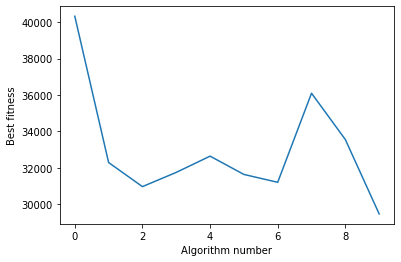

In [188]:
best_fitness = []
for i in range(10):
    _,best = simple_ga(g,pop_size = 1000, num_iters = 100, tournament_size = 5, mutation_prob = 0.05, use_elitism = True, elitism_size = 10,Stop = 10)
    best_fitness.append(best)
print(len(best_fitness))
plt.plot([i for i in range(len(best_fitness))],best_fitness)
plt.xlabel("Algorithm number")
plt.ylabel("Best fitness")

In [189]:
def local_search(individual,max_iterations=10):
    for _ in range(max_iterations):
        old_fitness = individual.fitness
        i, j = random.sample(range(len(individual.code)), 2)
        individual.code[i], individual.code[j] = individual.code[j], individual.code[i]
        new_fitness = individual.fitness
        if old_fitness < new_fitness:
            individual.code[i], individual.code[j] = individual.code[j], individual.code[i]
            
    return individual, individual.fitness

In [190]:
i, ifit = local_search(Indivudal(g),10)

In [191]:
print(i.code)
print(ifit)

[13, 0, 1, 25, 6, 12, 8, 24, 10, 19, 3, 7, 15, 14, 20, 11, 4, 9, 17, 27, 22, 5, 26, 23, 18, 28, 2, 21, 16]
106152.83626578328


In [192]:
def GA_with_LS(g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size):
    if not use_elitism :
        elitism_size = 0
        if pop_size % 2 == 1:
            pop_size += 1
    
    best_fitnesses = []
    if use_elitism and (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    
    population = [Indivudal(g) for _ in range(pop_size)]
    best_individual = min(population, key=lambda x: x.fitness)
    best_fitnesses.append(best_individual.fitness)
    new_population = [Indivudal(g) for _ in range(pop_size)]
    
    no_difference = 0
    for i in range(num_iters):
        iter = i
        #print(i)
        if use_elitism:
            population.sort()
            
            new_population[:elitism_size] = population[:elitism_size]
        
        for i in range(elitism_size, pop_size, 2):
            
            for j in range(local_size):
                ind = random.randrange(len(population))
                local_search(population[j])
                
            parent1_idx = selection(population, tournament_size, None)
            parent2_idx = selection(population, tournament_size, parent1_idx)
            
            crossover1(population[parent1_idx],
                      population[parent2_idx],
                      new_population[i],
                      new_population[i+1])
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #print(new_population[i].code)
            #print(new_population[i+1].code)
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
        
        population[:] = new_population[:]
        best_individual = min(population, key=lambda x: x.fitness)
        best_fitness = best_individual.fitness
        best_fitnesses.append(best_fitness)
        
        if best_fitness == best_fitnesses[iter]:
            no_difference += 1
        
        if no_difference == Stop:
            break
        #print(best_individual.code)
        #print(best_individual.fitness)
        #print(1 / best_individual.fitness)
        
        
    
    best_individual = min(population, key=lambda x: x.fitness)
    print("Best individual time:")
    print(best_individual.code)
    print(f"Fitness of best indvidual {best_individual.fitness}")
    print(1 / best_individual.fitness)
    
    return best_fitnesses, best_individual.fitness

In [193]:
start = time.time()
best_fitnesses,_ = GA_with_LS(g,pop_size=1000,number_iters = 80,tournament_size=5,mutation_prob =0.05,use_elitsm=True,elitism_size = 10,stop = 10,local_size = 10)
end = time.time()
print(f"Execution time {end - start}s")

Best individual time:
[27, 13, 19, 22, 18, 16, 3, 1, 0, 21, 23, 20, 15, 2, 5, 10, 6, 25, 26, 8, 17, 12, 11, 14, 9, 4, 28, 24, 7]
Fitness of best indvidual 32467.805166959457
3.079974130858837e-05
Execution time 9.493046283721924s


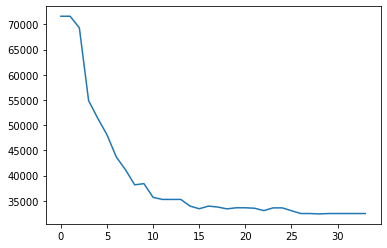

In [194]:
plt.plot([i for i in range(len(best_fitnesses))],best_fitnesses)

Best individual time:
[20, 19, 24, 26, 23, 15, 13, 12, 7, 3, 4, 0, 1, 5, 10, 9, 2, 6, 8, 11, 14, 18, 21, 22, 17, 16, 25, 27, 28]
Fitness of best indvidual 33058.51868780811
3.024938925556871e-05
Best individual time:
[23, 15, 13, 12, 20, 28, 22, 21, 14, 7, 8, 6, 2, 3, 4, 5, 0, 1, 10, 9, 11, 18, 17, 16, 25, 27, 19, 26, 24]
Fitness of best indvidual 34717.71388485439
2.8803739880932947e-05
Best individual time:
[1, 0, 6, 8, 15, 23, 26, 24, 25, 19, 16, 27, 28, 22, 21, 20, 18, 14, 17, 13, 12, 11, 10, 9, 7, 2, 3, 4, 5]
Fitness of best indvidual 33410.77564815595
2.993046346875797e-05
Best individual time:
[16, 17, 18, 14, 11, 12, 8, 6, 2, 3, 0, 1, 5, 10, 9, 4, 7, 13, 19, 15, 23, 26, 24, 25, 27, 28, 22, 21, 20]
Fitness of best indvidual 31869.758011068236
3.137770922680694e-05
Best individual time:
[28, 22, 17, 18, 21, 20, 14, 12, 16, 13, 24, 26, 23, 15, 8, 2, 3, 7, 11, 9, 10, 1, 0, 5, 4, 6, 19, 25, 27]
Fitness of best indvidual 39255.45367192835
2.5474167445811533e-05
Best individual time:


Text(0, 0.5, 'Best fitness')

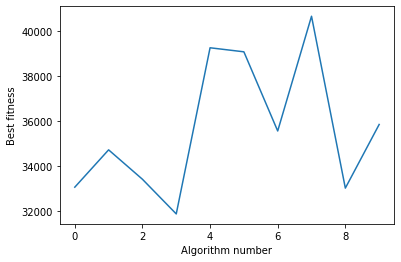

In [196]:
#g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size
best_fitness = []
for i in range(10):
    _,best = simple_ga(g,pop_size = 1000, num_iters = 100, tournament_size = 5, mutation_prob = 0.05, use_elitism = True, elitism_size = 10,Stop = 10)
    best_fitness.append(best)
print(len(best_fitness))
plt.plot([i for i in range(len(best_fitness))],best_fitness)
plt.xlabel("Algorithm number")
plt.ylabel("Best fitness")

In [48]:
def GA_with_LS_single(g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size,result_queue):
    if not use_elitism :
        elitism_size = 0
        if pop_size % 2 == 1:
            pop_size += 1
    
    best_fitnesses = []
    if use_elitism and (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    
    population = [Indivudal(g) for _ in range(pop_size)]
    best_individual = min(population, key=lambda x: x.fitness)
    best_fitnesses.append(best_individual.fitness)
    new_population = [Indivudal(g) for _ in range(pop_size)]
    
    no_difference = 0
    for i in range(num_iters):
        iter = i
        #print(i)
        if use_elitism:
            population.sort()
            
            new_population[:elitism_size] = population[:elitism_size]
        
        for i in range(elitism_size, pop_size, 2):
            
            for j in range(local_size):
                ind = random.randrange(len(population))
                local_search(population[j])
                
            parent1_idx = selection(population, tournament_size, None)
            parent2_idx = selection(population, tournament_size, parent1_idx)
            
            crossover1(population[parent1_idx],
                      population[parent2_idx],
                      new_population[i],
                      new_population[i+1])
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #print(new_population[i].code)
            #print(new_population[i+1].code)
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
        
        population[:] = new_population[:]
        best_individual = min(population, key=lambda x: x.fitness)
        best_fitness = best_individual.fitness
        best_fitnesses.append(best_fitness)
        
        if best_fitness == best_fitnesses[iter]:
            no_difference += 1
        
        if no_difference == Stop:
            break
        #print(best_individual.code)
        #print(best_individual.fitness)
        #print(1 / best_individual.fitness)
        
        
    
    result = best_individual.fitness, best_individual.code
    result_queue.put(result)


In [199]:
def parallel_ga_ls(g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size,num_processes):
    # Create a list of arguments for each process
    processes = []
    result_queue = multiprocessing.Queue()
    for i in range(num_processes):
        args = (g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size,result_queue)
        process = multiprocessing.Process(target=GA_with_LS_single, args=args)
        process.start()
   
        processes.append(process)

    # Start and join all processes
    #for process in processes:
    #    process.start()


    for process in processes:
        process.join()
    results = []
    while not result_queue.empty():
        result = result_queue.get()
        results.append(result)
    print("\\\\")
    results.sort()
    print(f"fitnes najbolje {results[0][0]}")
    print(f"Kod najbolje jedinke {results[0][1]}")
    
    return results[0][0]
     
  
    

In [200]:
parallel_ga_ls( g,
        num_iters = 20,
        use_elitism = True,
        pop_size = 1000,
        elitism_size = 10,
        mutation_prob = 0.15,
        tournament_size = 10,
        Stop = 10,
        local_size = 10,
        num_processes = 4
    )

\\
fitnes najbolje 31774.41172970259
Kod najbolje jedinke [23, 15, 25, 27, 28, 21, 17, 22, 20, 13, 8, 6, 2, 3, 4, 0, 1, 5, 9, 10, 11, 7, 12, 14, 18, 16, 19, 24, 26]


31774.41172970259

\\
fitnes najbolje 30664.540754919
Kod najbolje jedinke [3, 26, 13, 28, 23, 27, 8, 19, 6, 17, 4, 24, 9, 15, 22, 14, 20, 12, 10, 2, 5, 1, 16, 7, 25, 21, 18, 0, 11]
\\
fitnes najbolje 30497.053444146477
Kod najbolje jedinke [28, 20, 2, 12, 3, 17, 16, 0, 10, 18, 7, 4, 9, 14, 5, 25, 27, 6, 15, 1, 11, 21, 26, 13, 23, 24, 8, 19, 22]
\\
fitnes najbolje 30444.528374831854
Kod najbolje jedinke [24, 0, 5, 28, 8, 17, 22, 23, 15, 26, 27, 9, 10, 14, 1, 11, 18, 12, 7, 6, 19, 4, 16, 21, 2, 3, 20, 25, 13]
\\
fitnes najbolje 31841.662869459407
Kod najbolje jedinke [24, 18, 0, 17, 1, 8, 19, 15, 12, 14, 6, 23, 27, 2, 4, 10, 22, 20, 28, 9, 26, 13, 21, 16, 11, 3, 5, 7, 25]
\\
fitnes najbolje 31578.589764091397
Kod najbolje jedinke [27, 25, 19, 26, 24, 23, 15, 8, 6, 2, 3, 1, 0, 5, 10, 9, 4, 7, 11, 12, 13, 14, 18, 17, 16, 20, 21, 22, 28]
\\
fitnes najbolje 31037.260856686902
Kod najbolje jedinke [22, 18, 16, 7, 25, 1, 8, 23, 9, 11, 15, 12, 27, 14, 4, 26, 0, 24, 17, 19, 13, 10, 28, 6, 3, 5, 20, 21, 2]
\\
fitn

Text(0, 0.5, 'Best fitness')

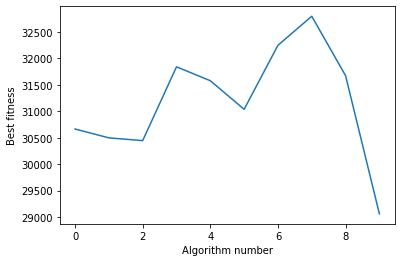

In [202]:
best_fitness = []
for i in range(10):
    best = parallel_ga_ls(g,pop_size = 1000, num_iters = 100, tournament_size = 5, mutation_prob = 0.05, use_elitism = True, elitism_size = 10,Stop = 10,local_size = 10,
        num_processes = 4)
    best_fitness.append(best)
print(len(best_fitness))
plt.plot([i for i in range(len(best_fitness))],best_fitness)
plt.xlabel("Algorithm number")
plt.ylabel("Best fitness")

#Initicialization with parralel best

In [203]:
def GA_with_LS_multiple(g,num_best,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size,result_queue):
    if not use_elitism :
        elitism_size = 0
        if pop_size % 2 == 1:
            pop_size += 1
    
    best_fitnesses = []
    if use_elitism and (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    population = [Indivudal(g) for _ in range(pop_size)]
    best_individual = min(population, key=lambda x: x.fitness)
    best_fitnesses.append(best_individual.fitness)
    new_population = [Indivudal(g) for _ in range(pop_size)]
    
    no_difference = 0
    for i in range(num_iters):
        iter = i
        #print(i)
        if use_elitism:
            population.sort()
            
            new_population[:elitism_size] = population[:elitism_size]
        
        for i in range(elitism_size, pop_size, 2):
            
            for j in range(local_size):
                ind = random.randrange(len(population))
                local_search(population[j])
                
            parent1_idx = selection(population, tournament_size, None)
            parent2_idx = selection(population, tournament_size, parent1_idx)
            
            crossover1(population[parent1_idx],
                      population[parent2_idx],
                      new_population[i],
                      new_population[i+1])
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #print(new_population[i].code)
            #print(new_population[i+1].code)
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
        
        population[:] = new_population[:]
        best_individual = min(population, key=lambda x: x.fitness)
        best_fitness = best_individual.fitness
        best_fitnesses.append(best_fitness)
        
        if best_fitness == best_fitnesses[iter]:
            no_difference += 1
        
        if no_difference == Stop:
            break
        #print(best_individual.code)
        #print(best_individual.fitness)
        #print(1 / best_individual.fitness)
        
    s = sorted(population,key=lambda x: x.fitness)
    best = [s[i] for i in range(num_best)]
    result = best
    result_queue.put(result)

In [208]:
def GA_with_LS_old_pop(old_pop,g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size):
    if not use_elitism :
        elitism_size = 0
        if pop_size % 2 == 1:
            pop_size += 1
    
    best_fitnesses = []
    if use_elitism and (pop_size - elitism_size) % 2 == 1:
        elitism_size += 1
    
    old_pop_size = len(old_pop)
    population = [Indivudal(g) for _ in range(pop_size)]
    population[:old_pop_size] = old_pop[:] 
    best_individual = min(population, key=lambda x: x.fitness)
    best_fitnesses.append(best_individual.fitness)
    new_population = [Indivudal(g) for _ in range(pop_size)]
    
    no_difference = 0
    for i in range(num_iters):
        iter = i
        #print(i)
        if use_elitism:
            population.sort()
            
            new_population[:elitism_size] = population[:elitism_size]
        
        for i in range(elitism_size, pop_size, 2):
            
            for j in range(local_size):
                ind = random.randrange(len(population))
                local_search(population[j])
                
            parent1_idx = selection(population, tournament_size, None)
            parent2_idx = selection(population, tournament_size, parent1_idx)
            
            crossover1(population[parent1_idx],
                      population[parent2_idx],
                      new_population[i],
                      new_population[i+1])
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            #print(new_population[i].code)
            #print(new_population[i+1].code)
            new_population[i].fitness = new_population[i].calc_fitness(g)
            new_population[i+1].fitness = new_population[i+1].calc_fitness(g)
        
        population[:] = new_population[:]
        best_individual = min(population, key=lambda x: x.fitness)
        best_fitness = best_individual.fitness
        best_fitnesses.append(best_fitness)
        
        if best_fitness == best_fitnesses[iter]:
            no_difference += 1
        
        if no_difference == Stop:
            break
        #print(best_individual.code)
        #print(best_individual.fitness)
        #print(1 / best_individual.fitness)
        
        
    
    best_individual = min(population, key=lambda x: x.fitness)
    print("Best individual time:")
    print(best_individual.code)
    print(f"Fitness of best indvidual {best_individual.fitness}")
    print(1 / best_individual.fitness)
    
    return best_fitnesses, best_individual.fitness

In [209]:
def parallel_ga_ls_2(g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size,num_processes):
    # Create a list of arguments for each process
    processes = []
    result_queue = multiprocessing.Queue()
    num_best = 5
    for i in range(num_processes):
        args = (g,num_best,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size,result_queue)
        process = multiprocessing.Process(target=GA_with_LS_multiple, args=args)
        process.start()
   
        processes.append(process)

    # Start and join all processes
    #for process in processes:
    #    process.start()


    for process in processes:
        process.join()
    results = []
    while not result_queue.empty():
        result = result_queue.get()
        results.append(result)
    print("\\\\")
    #print(results)
    old_pop = [item for sublist in results for item in sublist]
    #print(old_pop)
    
    _,best_fitness = GA_with_LS_old_pop(old_pop,g,pop_size, num_iters, tournament_size, mutation_prob, use_elitism, elitism_size,Stop,local_size)
    
    return best_fitness
    #new population of best individuals 
    

\\
Best individual time:
[22, 9, 19, 12, 3, 25, 20, 24, 26, 28, 15, 1, 18, 2, 11, 16, 23, 27, 7, 10, 8, 4, 0, 17, 21, 14, 6, 5, 13]
Fitness of best indvidual 32539.932129440236
3.073147159687092e-05
Vreme 15.234431743621826s
\\
Best individual time:
[4, 12, 17, 14, 10, 23, 15, 0, 9, 24, 19, 26, 16, 20, 13, 2, 1, 28, 11, 5, 6, 8, 21, 27, 22, 7, 25, 3, 18]
Fitness of best indvidual 33928.22973849173
2.947398103902531e-05
\\
Best individual time:
[18, 17, 13, 0, 11, 1, 24, 3, 6, 7, 27, 10, 21, 14, 5, 22, 20, 8, 23, 26, 16, 4, 15, 12, 19, 28, 25, 9, 2]
Fitness of best indvidual 31372.06678700017
3.187548996339559e-05
\\
Best individual time:
[1, 22, 19, 18, 4, 3, 17, 21, 15, 8, 20, 11, 23, 5, 12, 2, 9, 24, 13, 14, 26, 28, 27, 0, 10, 25, 7, 6, 16]
Fitness of best indvidual 31426.666729957957
3.182011024563208e-05
\\
Best individual time:
[6, 14, 12, 1, 3, 0, 20, 26, 23, 28, 19, 7, 11, 27, 18, 17, 10, 15, 8, 2, 25, 21, 16, 24, 5, 22, 9, 4, 13]
Fitness of best indvidual 32045.531652162223
3.1

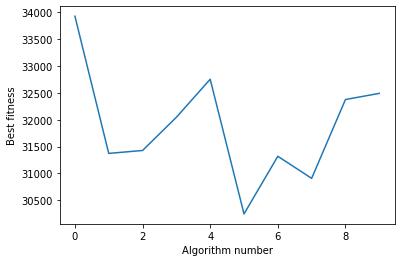

In [211]:
if __name__ == "__main__":

    # ga_ls( graph,
    #     num_iters = 20,
    #     use_elitism = True,
    #     population_size = 1000,
    #     elitism_size = 10,
    #     mutation_prob = 0.15,
    #     tournament_size = 10,
    # )
    
    multiprocessing.freeze_support()  
    
    start = time.time()

    parallel_ga_ls_2( g,
        num_iters = 20,
        use_elitism = True,
        pop_size = 1000,
        elitism_size = 10,
        mutation_prob = 0.15,
        tournament_size = 10,
        Stop = 10,
        local_size = 10,
        num_processes = 4
    )
    
    end = time.time()

    
    print(f"Vreme {end-start}s")
    
    best_fitness = []
    for i in range(10):
        best = parallel_ga_ls_2(g,pop_size = 1000, num_iters = 100, tournament_size = 5, mutation_prob = 0.05, use_elitism = True, elitism_size = 10,Stop = 10,local_size = 10,
        num_processes = 4)
        best_fitness.append(best)

    plt.plot([i for i in range(len(best_fitness))],best_fitness)
    plt.xlabel("Algorithm number")
    plt.ylabel("Best fitness")
    
    